In [1]:
import pandas as pd
import numpy as np
import os,sys

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolor
from plotly.subplots import make_subplots
from matplotlib.patches import Patch
import matplotlib
import pickle
base_dir = os.getcwd() 
from matplotlib.ticker import FuncFormatter
# sys.path.insert(0, os.path.abspath(os.path.join(base_dir, '..')))

In [2]:
Comparison_Pool = ['CNN','OmniAnomaly', 'USAD', 'AutoEncoder', 'KMeansAD', 'CBLOF', 'OCSVM', 'FITS', 'LOF','HBOS','MCD',
                    'AnomalyTransformer','KNN',  'TimesNet', 'TranAD', 'IForest', 'PCA', "RobustPCA", 'LSTMAD'] 


DNN_pool = ['USAD','CNN', 'OmniAnomaly', 'FITS', 'TimesNet', 'TranAD', 'LSTMAD', 'AnomalyTransformer', 'AutoEncoder']

Streaming_Pool = ['LODA', 'RRCF', 'HSTree', 'RSHash', 'MemStream', 'MCOD', 'LEAP', 'xStream', 'SWKNN', 'SDOstream']

In [6]:
Full_Pool = Streaming_Pool + Comparison_Pool

df_AUC_PR_off = pd.read_csv('benchmark_eval_results/static/AUC-PR.csv')
df_AUC_PR_on = pd.read_csv('benchmark_eval_results/online/AUC-PR.csv')
df_AUC_PR_stream = pd.read_csv('benchmark_eval_results/streaming/AUC-PR.csv')
df_AUC_PR_full = pd.merge(df_AUC_PR_on, df_AUC_PR_stream, on='file')

df_AUC_PR_full.head()

meta_feature_df = pd.read_csv('../meta_data/meta_features.csv')
mean_throughput_df = pd.read_csv('benchmark_eval_results/time/mean_throughput.csv')
merged_throughput_df = pd.merge(
    meta_feature_df,
    mean_throughput_df,
    left_on='file_name',
    right_on='file',
    how='inner'
)


merged_throughput_df = merged_throughput_df[['file',  'CNN', 'OmniAnomaly', 'PCA', 'USAD', 'AutoEncoder', 'KMeansAD',
       'CBLOF', 'OCSVM', 'RobustPCA', 'FITS', 'IForest', 'HBOS', 'TimesNet',
       'KNN', 'TranAD', 'LOF', 'AnomalyTransformer', 'MCD', 'LODA','LSTMAD', 'RRCF',
       'RSHash', 'HSTree', 'MemStream', 'LEAP', 'MCOD', 'SWKNN', 'xStream',
       'SDOstream', 'features']]


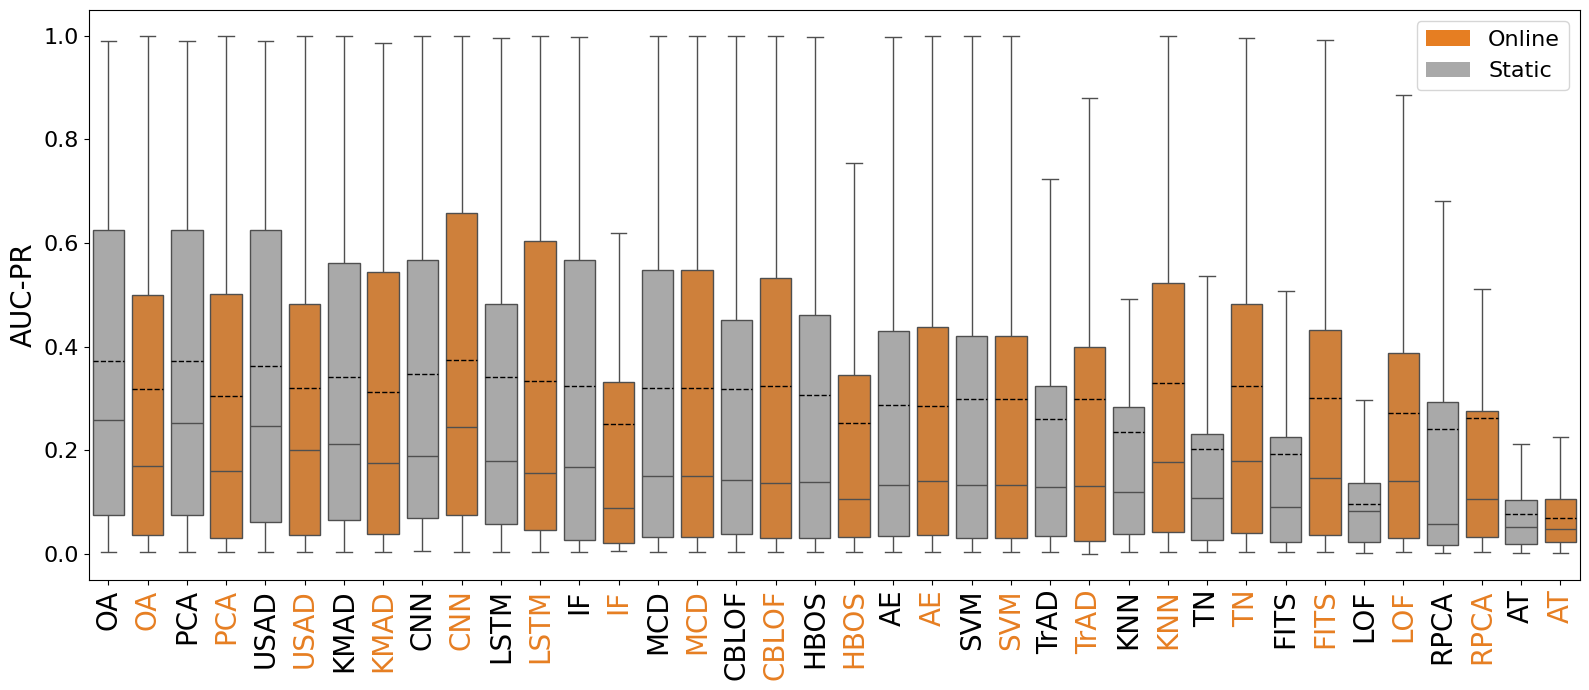

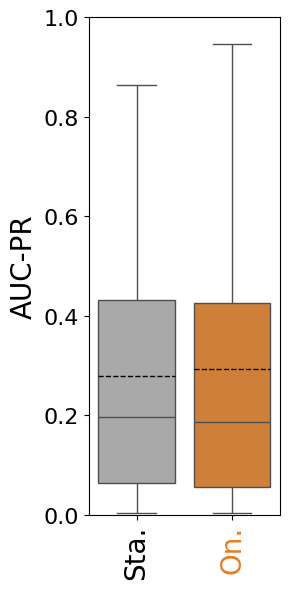

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

mean_base_df = pd.DataFrame()
mean_base_df['AUC_PR_Rank'] = df_AUC_PR_off[Comparison_Pool].median().rank(ascending=False)
sorted_mean_base_df = mean_base_df.sort_values(by='AUC_PR_Rank', ascending=True)
ranked_model_list = sorted_mean_base_df.index

plotted_base_comp_df = {}
for model in ranked_model_list:
    plotted_base_comp_df[f"{model}_static"] = df_AUC_PR_off[model]
    plotted_base_comp_df[f"{model}_online"] = df_AUC_PR_on[model]

df = pd.DataFrame(plotted_base_comp_df)

median_perf = pd.DataFrame()
median_perf['Static'] = df_AUC_PR_off[Comparison_Pool].mean(axis=1).values
median_perf['Online'] = df_AUC_PR_on[Comparison_Pool].mean(axis=1).values

color_map = {}
for col in df.columns:
    if col.endswith('_online'):
        color_map[col] = '#E67E22'
    elif col.endswith('_static'):
        color_map[col] = '#A9A9A9'

plt.figure(figsize=(16, 7))
sns.reset_orig()

ax = sns.boxplot(data=df, showfliers=False,
                 meanprops=dict(color='k', linestyle='--'), 
                 showmeans=True, meanline=True,
                 palette=color_map)

legend_elements = [
    Patch(facecolor='#E67E22', label='Online'),
    Patch(facecolor='#A9A9A9', label='Static')
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=16)

display_map = {
    "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN", "TranAD": "TrAD",
    "OCSVM": "SVM", "LSTMAD":"LSTM", "RobustPCA": "RPCA", "AnomalyTransformer": "AT",
    "KMeansAD": "KMAD", "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
    'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST', "SWKNN": 'SKNN'
}

display_labels = []
for col in df.columns:
    base_model = col.split('_')[0] if '_' in col else col
    display_labels.append(display_map.get(base_model, base_model))

plt.xticks(ticks=range(len(df.columns)), labels=display_labels, rotation=90, fontsize=20)

for tick_label, col_name in zip(ax.get_xticklabels(), df.columns):
    if col_name.endswith('_online'):
        tick_label.set_color('#E67E22')

plt.yticks(fontsize=16)
plt.ylabel('AUC-PR', fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(3, 6))

ax = sns.boxplot(data=median_perf, showfliers=False,
                 meanprops=dict(color='k', linestyle='--'), 
                 showmeans=True, meanline=True, 
                 palette=['#A9A9A9','#E67E22'])

plt.yticks(fontsize=16)
plt.ylim(0,1)
plt.xticks(ticks=range(len(median_perf.columns)),
           labels=['Sta.', 'On.'],
           rotation=90,
           fontsize=20)

for tick_label, col_name in zip(ax.get_xticklabels(), median_perf.columns):
    if col_name == 'Online':
        tick_label.set_color('#E67E22')

plt.ylabel('AUC-PR', fontsize=20)
plt.tight_layout()
plt.show()

In [11]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

CATEGORIES = ['Sensor', 'HumanActivity', 'Medical', 'Environment', 'Facility']
TOP_STATIC = ['OmniAnomaly', 'PCA', 'USAD', 'KMeansAD']
TOP_ONLINE = ['CNN', 'USAD', 'TimesNet', 'KNN']
COLOR_ONLINE = '#E67E22'
COLOR_STATIC = '#A9A9A9'

CATEGORY_PATTERN = re.compile(
    r'_(Sensor|HumanActivity|Medical|Environment|Facility|Finance)(?:_|$)',
    re.IGNORECASE
)

def extract_category(name: str) -> str:
    if not isinstance(name, str):
        return None
    m = CATEGORY_PATTERN.search(name)
    if m:
        cat = m.group(1)
        for c in CATEGORIES:
            if c.lower() == cat.lower():
                return c
    if '_tr_' in name:
        token = name.split('_tr_')[0].split('_')[-1]
        for c in CATEGORIES:
            if token.lower() == c.lower():
                return c
    return None

def mean_per_category(df: pd.DataFrame, model_cols) -> pd.Series:
    row_mean = df[model_cols].mean(axis=1, skipna=True)
    return df.assign(row_mean=row_mean).groupby('Category')['row_mean'].mean()

# Goal: Generate a Radar (Spider) Chart comparing average performance across different dataset domains
def spider_plot(df_ref, df_new, TOP_REF, TOP_NEW, COLOR_REF, COLOR_NEW, label_ref, label_new, title):
    df_ref = df_ref.copy()
    df_new  = df_new.copy()

    df_ref['Category'] = df_ref['file'].apply(extract_category)
    df_new['Category']  = df_new['file'].apply(extract_category)

    mean_ref = mean_per_category(df_ref, TOP_REF)
    mean_new  = mean_per_category(df_new, TOP_NEW)

    labels = mean_ref.index.tolist()
    values_ref = mean_ref.values
    values_new  = mean_new.values

    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    rad_ref = np.concatenate([values_ref, values_ref[:1]])
    rad_new  = np.concatenate([values_new,  values_new[:1]])

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.set_ylim(0, 0.8)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=10)
    ax.tick_params(axis='y', labelsize=10)

    ax.plot(angles, rad_ref, color=COLOR_REF, linewidth=2.5, label=label_ref)
    ax.fill(angles, rad_ref, color=COLOR_REF, alpha=0.2)

    ax.plot(angles, rad_new,  color=COLOR_NEW, linewidth=2.5, label=label_new)
    ax.fill(angles, rad_new,  color=COLOR_NEW, alpha=0.2)

    legend_elements = [
        Patch(facecolor=COLOR_NEW, edgecolor='none', label=label_new),
        Patch(facecolor=COLOR_REF, edgecolor='none', label=label_ref),
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.15), frameon=False, fontsize=16)

    ax.set_title(title, va='bottom', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- CONCEPT DRIFT ANALYSIS LOGIC ---

cd_df = pd.read_csv("benchmark_eval_results/CD.csv")
cd_df["type"] = cd_df["type"].str.strip()
MAIN_DRIFTS = ["continuous", "change_point", "random_walk", "periodic"]

def normalize_tokens(type_str):
    tokens = type_str.split()
    tokens = [t.strip().lower() for t in tokens]
    normalized = []
    for t in tokens:
        if t in MAIN_DRIFTS:
            normalized.append(t)
        elif "periodic" in t:
            normalized.append("periodic")
        elif "change" in t:
            normalized.append("change_point")
    return list(sorted(set(normalized)))

def compute_drift_list(row):
    if row["CD"] == 0:
        return ["no_drift"]
    return normalize_tokens(row["type"])

cd_df["drift_list"] = cd_df.apply(compute_drift_list, axis=1)
DRIFT_LISTS = dict(zip(cd_df["file"], cd_df["drift_list"]))

def explode_on_drift(df):
    df = df.copy()
    df["drift_list"] = df["file"].apply(lambda f: DRIFT_LISTS.get(f, ["no_drift"]))
    return df.explode("drift_list").rename(columns={"drift_list": "drift_type"})

def mean_per_drift(df, model_cols):
    row_mean = df[model_cols].mean(axis=1, skipna=True)
    return df.assign(row_mean=row_mean).groupby('drift_type')['row_mean'].mean()

# Goal: Generate a Radar Chart specifically comparing performance across various types of Concept Drifts
def spider_plot_CD(df_ref, df_new, TOP_REF, TOP_NEW, COLOR_REF, COLOR_NEW, label_ref, label_new, title):
    plt.close('all')
    df_ref = explode_on_drift(df_ref)
    df_new = explode_on_drift(df_new)

    mean_ref = mean_per_drift(df_ref, TOP_REF)
    mean_new = mean_per_drift(df_new, TOP_NEW)

    labels = mean_ref.index.tolist()
    values_ref = mean_ref.values
    values_new = mean_new.values

    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    angles = np.concatenate([angles, angles[:1]])

    rad_ref = np.concatenate([values_ref, values_ref[:1]])
    rad_new = np.concatenate([values_new, values_new[:1]])

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.set_ylim(0, 0.4)
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)

    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.set_yticklabels(['0.1','0.2','0.3','0.4'])

    ax.plot(angles, rad_ref, color=COLOR_REF, linewidth=2.5, label=label_ref)
    ax.fill(angles, rad_ref, color=COLOR_REF, alpha=0.2)

    ax.plot(angles, rad_new, color=COLOR_NEW, linewidth=2.5, label=label_new)
    ax.fill(angles, rad_new, color=COLOR_NEW, alpha=0.2)

    legend_elements = [
        Patch(facecolor=COLOR_NEW, label=label_new),
        Patch(facecolor=COLOR_REF, label=label_ref),
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.15), frameon=False, fontsize=16)

    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

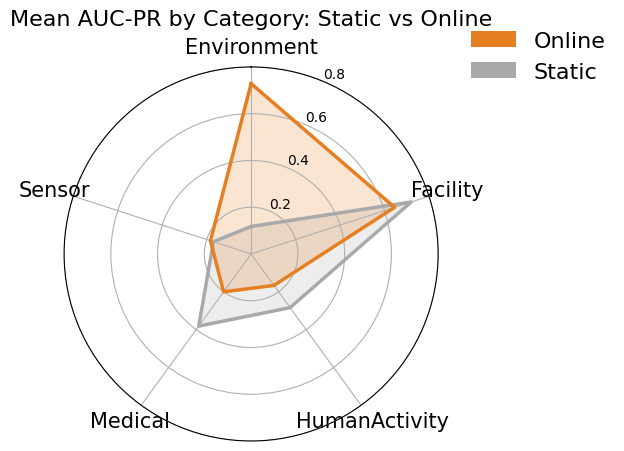

In [12]:
# CATEGORIES = ['Sensor', 'HumanActivity', 'Medical', 'Environment', 'Facility']#, 'Finance']
# TOP_STATIC = ['OmniAnomaly', 'PCA', 'USAD', 'KMeansAD']
# TOP_ONLINE = ['CNN', 'USAD', 'TimesNet', 'KNN']
COLOR_ONLINE = '#E67E22'
COLOR_STATIC = '#A9A9A9'

spider_plot(df_ref = df_AUC_PR_off, 
            df_new = df_AUC_PR_on, 
            TOP_REF = TOP_STATIC, 
            TOP_NEW = TOP_ONLINE, 
            COLOR_REF = COLOR_STATIC, 
            COLOR_NEW = COLOR_ONLINE,
            label_ref='Static',
            label_new='Online',
            title = "Mean AUC-PR by Category: Static vs Online")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.colors as mcolors

def plot_gain_online_vs_static(
    df_AUC_PR_off: pd.DataFrame,
    df_AUC_PR_on: pd.DataFrame,
    metric: str = "absolute",
    figsize: tuple = (12, 6),
    savepath: str | None = None,
    show: bool = True,
    title: str | None = None,
    annotate: bool = False,
):
    off_idxed = df_AUC_PR_off.set_index('file') if 'file' in df_AUC_PR_off.columns else df_AUC_PR_off.copy()
    on_idxed  = df_AUC_PR_on.set_index('file')  if 'file' in df_AUC_PR_on.columns  else df_AUC_PR_on.copy()

    common_files = off_idxed.index.intersection(on_idxed.index)
    if len(common_files) == 0:
        raise ValueError("No common files between df_AUC_PR_off and df_AUC_PR_on.")

    off = off_idxed.loc[common_files]
    on  = on_idxed.loc[common_files]

    common_models = sorted(set(off.columns) & set(on.columns))
    if not common_models:
        raise ValueError("No common model columns between the two DataFrames.")

    if metric == "absolute":
        values = on[common_models].mean(axis=0, skipna=True) - off[common_models].mean(axis=0, skipna=True)
        y_label = "Mean AUC-PR gain"
        if title is None:
            title = "Mean AUC-PR Gain (Online − Static) per model"
    elif metric == "relative":
        values = (on[common_models].mean(axis=0, skipna=True) - off[common_models].mean(axis=0, skipna=True)) / off[common_models].mean(axis=0, skipna=True) * 100
        y_label = "Mean % improvement vs Static"
        if title is None:
            title = "Mean % Improvement (Online vs Static) per model"
    else:
        raise ValueError("metric must be 'absolute' or 'relative'.")

    values_sorted = values.sort_values(ascending=False)

    cmap = LinearSegmentedColormap.from_list("darkred_white_darkgreen", ["#8B0000", "#FFFFFF", "#006400"])
    vmin, vmax = float(values_sorted.min()), float(values_sorted.max())
    
    if np.isclose(vmin, vmax):
        m = abs(vmax)
        vmin, vmax = -m, m
    else:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
        
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    rgba_colors = [cmap(norm(val)) for val in values_sorted.values]
    hex_colors = [mcolors.to_hex(c) for c in rgba_colors]

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(values_sorted.index, values_sorted.values,
                  color=rgba_colors, edgecolor="k", linewidth=0.8, width=0.9)

    ax.axhline(0.0, color="black", linewidth=1.0)
    ax.set_title(title, fontsize=25)
    ax.set_ylabel(y_label, fontsize=23)
    ax.set_ylim(-0.08, 0.2)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlim(-0.5, len(values_sorted) - 0.5)

    display_map = {
        "OmniAnomaly": "OA",
        "AutoEncoder": "AE",
        "TimesNet": "TN",
        "RobustPCA": "RobPCA",
        "AnomalyTransformer": "AT",
        "KMeansAD": "KMAD",
    }
    display_labels = [display_map.get(name, name) for name in values_sorted.index]

    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=90, ha="center", fontsize=23)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    if annotate:
        for rect, val in zip(bars, values_sorted.values):
            ax.annotate(f"{val:.2f}" + ("%" if metric == "relative" else ""),
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=20)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    return pd.DataFrame({"value": values_sorted.values, "color": hex_colors}, index=values_sorted.index)



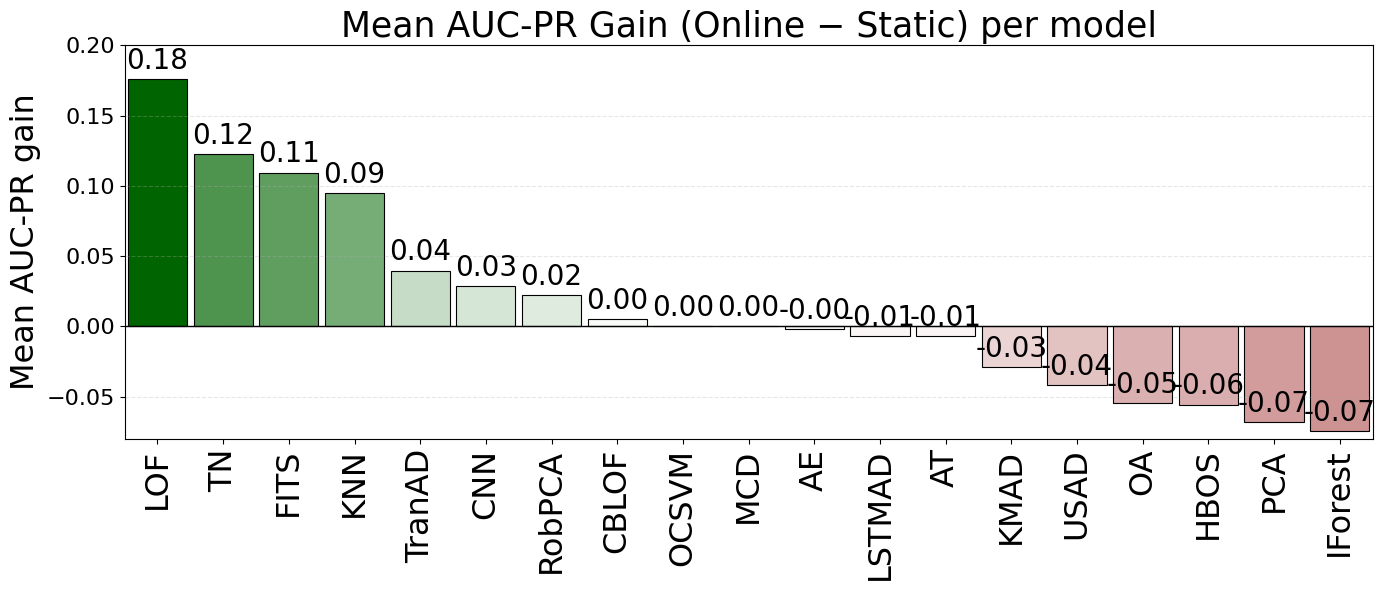

In [14]:

mean_gain_sorted = plot_gain_online_vs_static(
    df_AUC_PR_off, df_AUC_PR_on,
    figsize=(14, 6),
    savepath=None,
    show=True,
    annotate=True,  
    metric= "absolute",
)

# print(mean_gain_sorted)


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

def plot_aucpr_online_vs_offline(
    off_df: pd.DataFrame,
    on_df: pd.DataFrame,
    agg: str | None = "mean",
    ad_meta_path: str = "../methods/AD_multi.csv",
    annotate: bool = True,
    figsize: tuple = (10, 8),
    alpha: float = 0.9,
    savepath: str | None = None,
    show: bool = False,
    axis_mode: str = "auto",
    model_cmap: str | None = "tab20",
):
    # Compare AUC-PR between Online and Static modes using a scatter plot.
    # The diagonal line y=x separates cases where Online is better (green zone) from Static (red zone).

    if agg not in (None, "mean", "median"):
        raise ValueError("agg must be one of: None, 'mean', 'median'.")

    common_models = [c for c in off_df.columns if c in on_df.columns]
    if len(common_models) == 0:
        raise ValueError("No common model columns between offline and online DataFrames.")

    off = off_df[common_models].copy()
    on  = on_df[common_models].copy()

    try:
        meta = pd.read_csv(ad_meta_path)
    except Exception as e:
        raise FileNotFoundError(f"Cannot read {ad_meta_path}: {e}")

    meta = meta[['AD_name', 'class', 'type']].dropna()
    model2class = dict(zip(meta['AD_name'], meta['class']))
    model2type  = dict(zip(meta['AD_name'], meta['type']))

    TYPE_COLORS = {
        ('Distance', 'Proximity'):      '#6baed6',
        ('Distance', 'Clustering'):     '#2171b5',
        ('Density',  'Distribution'):   '#41ab5d',
        ('Density',  'Tree'):           '#006d2c',
        ('Density',  'Encoding'):       '#a1d99b',
        ('Prediction','Forecasting'):    '#fb6a4a',
        ('Prediction','Reconstruction'): '#a50f15',
    }
    CLASS_BASE = {'Distance': '#1f77b4', 'Density': '#2ca02c', 'Prediction': '#d62728'}

    def get_color_for_model(model: str) -> str:
        c, t = model2class.get(model), model2type.get(model)
        return TYPE_COLORS.get((c, t), CLASS_BASE.get(c, "#7f7f7f"))

    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    all_x, all_y = [], []
    legend_entries = {}

    if agg in ("mean", "median"):
        reducer_off = off.mean if agg == "mean" else off.median
        off_agg = reducer_off(axis=0, skipna=True)
        reducer_on = on.mean if agg == "mean" else on.median
        on_agg = reducer_on(axis=0, skipna=True)

        for model in common_models:
            x, y = float(off_agg[model]), float(on_agg[model])
            if np.isnan(x) or np.isnan(y): continue
            
            color = get_color_for_model(model)
            ax.scatter(x, y, s=70, color=color, edgecolor="k", alpha=alpha)
            all_x.append(x); all_y.append(y)

            if annotate:
                ax.annotate(model, (x, y), xytext=(5, 3), textcoords="offset points", fontsize=9)
            
            legend_entries[(model2class.get(model), model2type.get(model))] = color
        
        title_suffix = f"(aggregation = {agg})"
        agg_stats = pd.DataFrame({"offline": off_agg, "online": on_agg, 
                                  "delta": on_agg - off_agg}).sort_values("delta", ascending=False)
    else:
        if (model_cmap is None) and (len(common_models) == 1):
            model = common_models[0]
            x_arr, y_arr = off[model].to_numpy(dtype=float), on[model].to_numpy(dtype=float)
            mask = ~np.isnan(x_arr) & ~np.isnan(y_arr)
            x_arr, y_arr = x_arr[mask], y_arr[mask]
            
            if x_arr.size > 0:
                # Color individual points by gain (Online - Static)
                cmap_gain = LinearSegmentedColormap.from_list("gain_map", ["#8B0000", "#FFFFFF", "#006400"])
                norm_gain = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
                ax.scatter(x_arr, y_arr, s=100, c=cmap_gain(norm_gain(y_arr - x_arr)), edgecolor="k")
                all_x.extend(x_arr.tolist()); all_y.extend(y_arr.tolist())
            title_suffix = model
        else:
            cmap = plt.get_cmap(model_cmap or "tab20", len(common_models))
            for i, model in enumerate(common_models):
                x_arr, y_arr = off[model].to_numpy(dtype=float), on[model].to_numpy(dtype=float)
                mask = ~np.isnan(x_arr) & ~np.isnan(y_arr)
                x_arr, y_arr = x_arr[mask], y_arr[mask]
                if x_arr.size == 0: continue
                
                ax.scatter(x_arr, y_arr, s=35, color=cmap(i), edgecolor="k", alpha=min(alpha, 0.85))
                all_x.extend(x_arr.tolist()); all_y.extend(y_arr.tolist())
            title_suffix = "(no aggregation)"
        agg_stats = None

    # Finalize plot formatting
    if not all_x: raise ValueError("No valid pairs to plot.")
    
    if axis_mode.lower() == "auto":
        min_val, max_val = min(min(all_x), min(all_y)), max(max(all_x), max(all_y))
        pad = (max_val - min_val) * 0.05 if max_val > min_val else 0.02
        xmin, xmax = max(0.0, min_val - pad), min(1.0, max_val + pad)
    else:
        xmin, xmax = 0.0, 1.0

    ax.plot([xmin, xmax], [xmin, xmax], color="red", linestyle="--", linewidth=3, label="y = x")
    ax.fill_between(np.linspace(xmin, xmax, 100), np.linspace(xmin, xmax, 100), xmax, color="#90EE90", alpha=0.05)
    ax.fill_between(np.linspace(xmin, xmax, 100), xmin, np.linspace(xmin, xmax, 100), color="#F08080", alpha=0.05)
    
    ax.set_xlim(xmin, xmax); ax.set_ylim(xmin, xmax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title_suffix, fontsize=25)
    ax.set_xlabel("AUC-PR Static", fontsize=20)
    ax.set_ylabel("AUC-PR Online", fontsize=20)
    ax.tick_params(axis='both', labelsize=16)

    if agg in ("mean", "median"):
        class_order = ['Distance', 'Density', 'Prediction']
        sorted_items = sorted(legend_entries.items(), key=lambda x: (class_order.index(x[0][0]) if x[0][0] in class_order else 99, str(x[0][1])))
        handles = [Patch(facecolor=col, edgecolor="k") for _, col in sorted_items]
        labels = [f"{c} — {t}" if t else f"{c}" for (c, t), _ in sorted_items]
        ax.legend(handles, labels, loc="best", fontsize=9, frameon=True)

    if savepath: plt.savefig(savepath, dpi=200, bbox_inches="tight")
    if show: plt.show()
    return {"common_models": common_models, "agg_stats": agg_stats}



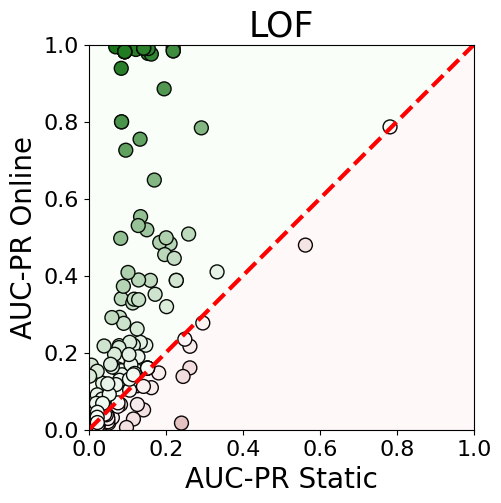

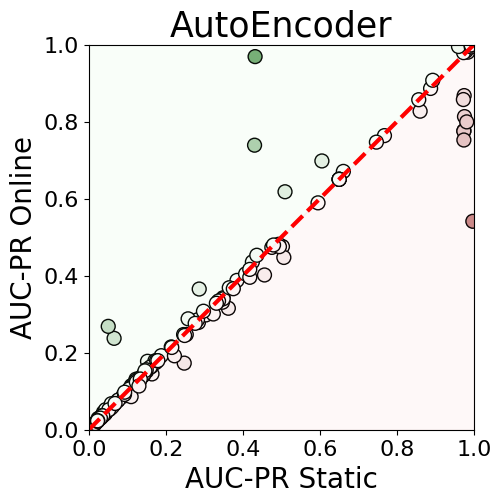

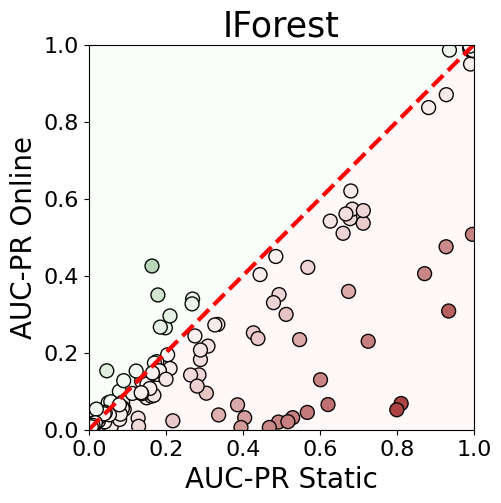

In [17]:
models_to_plot = ['LOF', 'AutoEncoder', 'IForest']
color_list = ['#006400', '#fefcfc', "#cd9292"]

for i, model in enumerate(models_to_plot):
    out = plot_aucpr_online_vs_offline(
    off_df= df_AUC_PR_off[[model]],
    on_df= df_AUC_PR_on[[model]],
    agg= None,           # "mean", "median", or None (pas d'agrégation)
    ad_meta_path = "../meta_data/AD_multi.csv",
    annotate =False,              # Annotations des modèles (pertinent surtout si agrégation)
    figsize = (5, 5),
    alpha = 0.9,
    savepath = None,
    show= True,                 # Laisser False par défauT
    model_cmap = None
)


### Online vs Streaming

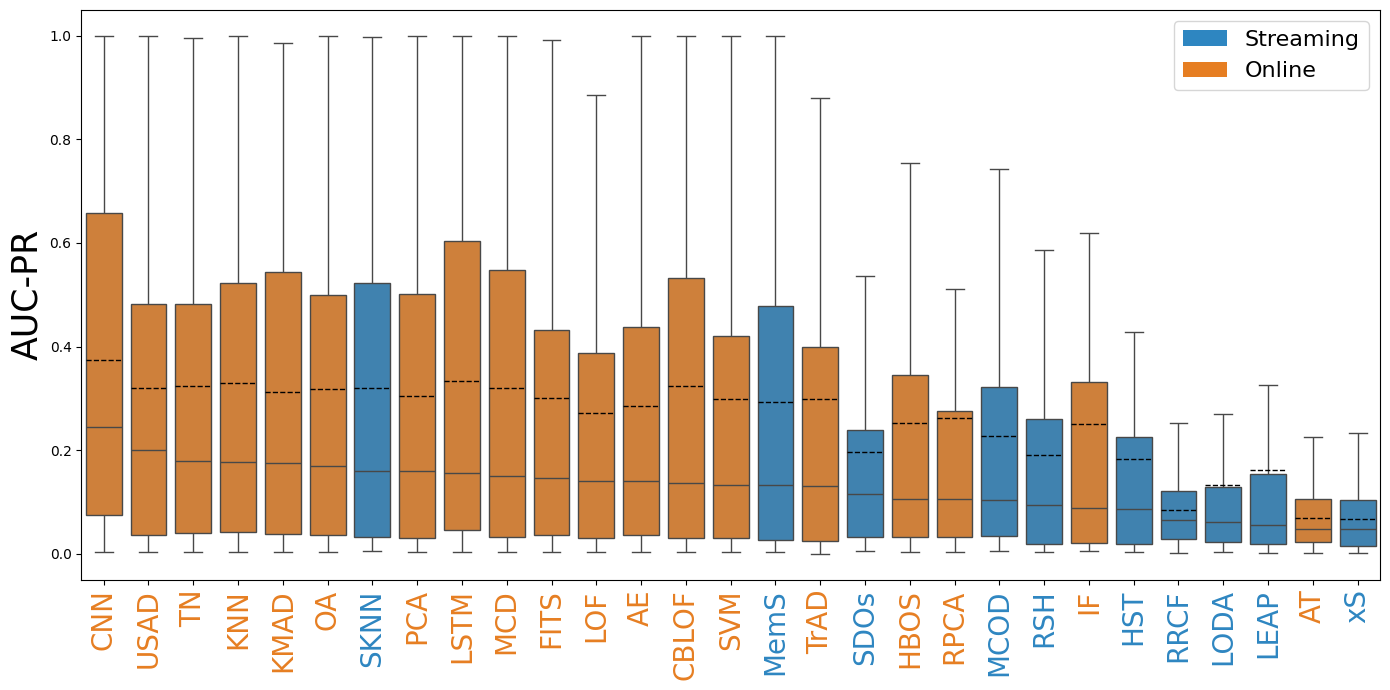

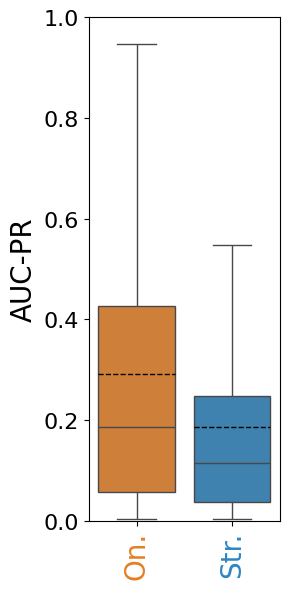

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch


mean_base_df = pd.DataFrame()
mean_base_df['AUC_PR_Rank'] = df_AUC_PR_full[Full_Pool].median().rank(ascending=False)
sorted_mean_base_df = mean_base_df.sort_values(by='AUC_PR_Rank', ascending=True)
ranked_model_list = sorted_mean_base_df.index

plotted_base_comp_df = {model: df_AUC_PR_full[model] for model in ranked_model_list}
df = pd.DataFrame(plotted_base_comp_df)

median_perf = pd.DataFrame()
median_perf['Online'] = df_AUC_PR_on[Comparison_Pool].mean(axis=1).values
median_perf['Streaming'] = df_AUC_PR_stream[Streaming_Pool].mean(axis=1).values

# --- PLOT 1: INDIVIDUAL MODEL PERFORMANCE (ONLINE VS STREAMING) ---

color_map = {}
for model in ranked_model_list:
    if model in Streaming_Pool:
        color_map[model] = '#2E86C1'
    elif model in Comparison_Pool:
        color_map[model] = '#E67E22'
    else:
        color_map[model] = "gray"

plt.figure(figsize=(14, 7))
sns.reset_orig()
ax = sns.boxplot(data=df, showfliers=False,
                 meanprops=dict(color='k', linestyle='--'), 
                 showmeans=True, meanline=True,
                 palette=color_map)

legend_elements = [
    Patch(facecolor='#2E86C1', label='Streaming'),
    Patch(facecolor='#E67E22', label='Online')
]
ax.legend(handles=legend_elements, loc="upper right", fontsize=16)

display_map = {
    "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN", "TranAD": "TrAD",
    "OCSVM": "SVM", "LSTMAD":"LSTM", "RobustPCA": "RPCA", "AnomalyTransformer": "AT",
    "KMeansAD": "KMAD", "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
    'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST', "SWKNN": 'SKNN'
}
display_labels = [display_map.get(name, name) for name in df.columns]

plt.xticks(ticks=range(len(df.columns)), labels=display_labels, rotation=90, fontsize=20)
for tick_label, col_name in zip(ax.get_xticklabels(), df.columns):
    if col_name in Streaming_Pool:
        tick_label.set_color('#2E86C1')
    elif col_name in Comparison_Pool:
        tick_label.set_color('#E67E22')

plt.ylabel('AUC-PR', fontsize=25)
plt.tight_layout()
plt.show()

# --- PLOT 2: AGGREGATED MEAN PERFORMANCE ---

plt.figure(figsize=(3, 6))

ax = sns.boxplot(data=median_perf, showfliers=False,
                 meanprops=dict(color='k', linestyle='--'), 
                 showmeans=True, meanline=True, 
                 palette=['#E67E22','#2E86C1'])

plt.yticks(fontsize=16)
plt.ylim(0,1)
plt.xticks(ticks=range(len(median_perf.columns)),
           labels=["On.", "Str."],
           rotation=90,
           fontsize=20)

for tick_label, col_name in zip(ax.get_xticklabels(), median_perf.columns):
    if col_name == 'Online':
        tick_label.set_color('#E67E22')
    elif col_name == 'Streaming':
        tick_label.set_color('#2E86C1')

plt.ylabel('AUC-PR', fontsize=20)
plt.tight_layout()
plt.show()

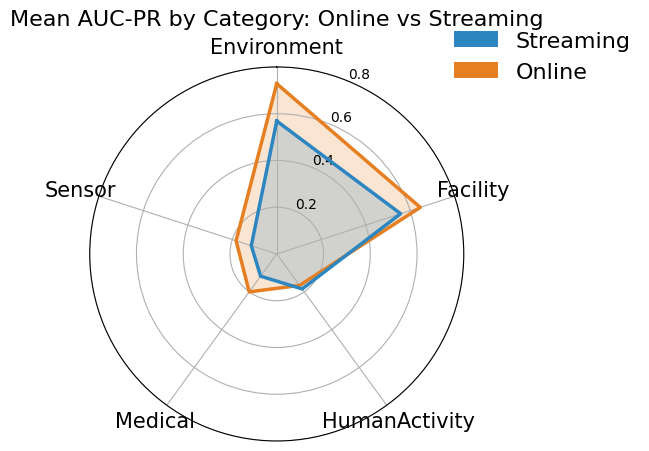

In [19]:
CATEGORIES = ['Sensor', 'HumanActivity', 'Medical', 'Environment', 'Facility']#, 'Finance']
TOP_STREAMING = ['SWKNN', 'MemStream', 'SDOstream', 'MCOD']
TOP_ONLINE = ['CNN', 'USAD', 'TimesNet', 'KNN']
COLOR_ONLINE = '#E67E22'
COLOR_STREAMING = '#2E86C1'

spider_plot(df_ref = df_AUC_PR_on, 
            df_new = df_AUC_PR_stream, 
            TOP_REF = TOP_ONLINE, 
            TOP_NEW = TOP_STREAMING, 
            COLOR_REF = COLOR_ONLINE, 
            COLOR_NEW = COLOR_STREAMING,
            label_ref='Online',
            label_new='Streaming',
            title = "Mean AUC-PR by Category: Online vs Streaming")

In [20]:
"""
# The following code was adapted from:
# https://github.com/thedatumorg/TSB-AD/tree/main/benchmark_exp
# Original Author: Qinghua Liu
# Apache License 2.0
"""

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import operator
import math
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman
import networkx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import seaborn as sns

def Friedman_Nemenyi(alpha=0.05, df_perf=None):
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # Record the maximum number of datasets
    max_nb_datasets = df_counts['count'].max()
    # Create a list of classifiers
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])

    # print('classifiers: ', classifiers)

    '''
    Expected input format for friedmanchisquare is:
                Dataset1        Dataset2        Dataset3        Dataset4        Dataset5
    classifer1
    classifer2
    classifer3 
    '''

    # Compute friedman p-value
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]

    # Decide whether to reject the null hypothesis
    # If p-value >= alpha: we cannot reject the null hypothesis. No statistical difference.
    if friedman_p_value >= alpha:
        print('No statistical difference...')
        return None,None,None
    # Friedman test OK
    # Prepare input for Nemenyi test
    data = []
    for c in classifiers:
        data.append(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
    data = np.array(data, dtype=np.float64)
    # Conduct the Nemenyi post-hoc test
    # print(classifiers)
    # Order is classifiers' order
    nemenyi = posthoc_nemenyi_friedman(data.T)

    # print(nemenyi)
    
    # Original code: p_values.append((classifier_1, classifier_2, p_value, False)), True: represents there exists statistical difference
    p_values = []

    # Comparing p-values with the alpha value
    for nemenyi_indx in nemenyi.index:
        for nemenyi_columns in nemenyi.columns:
            if nemenyi_indx < nemenyi_columns:
                if nemenyi.loc[nemenyi_indx, nemenyi_columns] < alpha:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], True))
                else:
                    p_values.append((classifiers[nemenyi_indx], classifiers[nemenyi_columns], nemenyi.loc[nemenyi_indx, nemenyi_columns], False))
            else: continue

    # Nemenyi test OK

    m = len(classifiers)

    # Sort by classifier name then by dataset name
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])

    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=np.unique(sorted_df_perf['dataset_name']))

    dfff = df_ranks.rank(ascending=False)
    # compute average rank
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    
    return p_values, average_ranks, max_nb_datasets

def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=200, textspace=1, reverse=False, filename=None, highlight=None, **kwargs):
    
    # ### added ###
    # colors = kwargs.get("colors", None)
    # names = list(names)  # s'assurer d'un list pour l'indexation
    # if isinstance(colors, dict):
    #     [colors.get(n, "#1f77b4") for n in names]
        
    # if colors is None:
    #     colors = ['black'] * len(names)

    # ### added ###

    width = width
    textspace = float(textspace)

    
    width = width
    textspace = float(textspace)
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # n th column
    def nth(l, n):
        n = lloc(l, n)
        # Return n th column
        return [a[n] for a in l]
    
    '''l is an array of array 
        [[......]
         [......]
         [......]]; 
    n is an integer'''
    # return an integer, count from front or from back.
    def lloc(l, n):
        if n < 0:
            return len(l[0]) + n
        else:
            return n
    # lr is an array of integers
    # Maximum range start from all zeros. Returns an iterable element of tuple.
    def mxrange(lr):
        # If nothing in the array
        if not len(lr):
            yield ()
        else:
            index = lr[0]
            # Check whether index is an integer.
            if isinstance(index, int):
                index = [index]
            # *index: index must be an iterable []
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    # Form a tuple, and generate an iterable value
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums
    # lowv: low value
    if lowv is None:
        '''int(math.floor(min(ssums))): select the minimum value in ssums and take floor.
           Then compare with 1 to see which one is the minimum.'''
        lowv = min(1, int(math.floor(min(ssums))))
    # highv: high value
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4
    # how many algorithms
    k = len(sums)

    # ### added ###
    
    # off = 0.25  # décalage vertical alternatif pour éviter les chevauchements
    # for i, (name, rank) in enumerate(zip(nnames, ssums)):
    #     col = colors[i]  # couleur par classifieur

    #     # petite barre à la position du rang
    #     line([(rankpos(rank), cline - 0.02),
    #           (rankpos(rank), cline + 0.18)],
    #          color=col, linewidth=2.0)

    #     # label du classifieur (alternance de y pour limiter les overlaps)
    #     ypos = cline + 0.45 + (i % 2) * off
    #     text(rankpos(rank), ypos, name, ha="center", va="center", size=12, color=col)
    # ### added ###

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace
    
    # Position of rank
    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        # Set up the format
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # set up the formats
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant + 2

    # matplotlib figure format setup
    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()

    hf = 1. / height
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    # Line plots
    def line(l, color='k', **kwargs):
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    # Add text to the plot
    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None

    # [lowv, highv], step size is 0.5
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        # If a is an integer
        if a == int(a):
            tick = bigtick
        # Plot a line
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    # Add text to the plot, only for integer value
    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24
    highlight_color = "#2E86C1" # La couleur demandée

    # Format pour la première moitié des algorithmes
    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
              linewidth=linewidth)

        # CHANGEMENT ICI : Condition pour la couleur
        color = highlight_color if (highlight and nnames[i] in highlight) else '#E67E22'
        
        text(textspace - 0.2, chei, filter_names(nnames[i]), color=color, ha="right", va="center", size=16)

    # Format pour la seconde moitié des algorithmes
    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
              linewidth=linewidth)

        # CHANGEMENT ICI : Condition pour la couleur
        color = highlight_color if (highlight and nnames[i] in highlight) else '#E67E22'
        
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]), color=color, ha="left", va="center", size=16)
        

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            
    start = cline + 0.2
    side = -0.02
    height = 0.1


    #Generate cliques and plot a line to connect elements in cliques    
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    # Plot a line to connect elements in cliques
    for clq in cliques:
        if len(clq) == 1:
            continue
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        # Test
        # print("ssums[min_idx]: {}; ssums[max_idx]: {}".format(ssums[min_idx], ssums[max_idx]))
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height

def form_cliques(p_values, nnames):
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1
    g = networkx.Graph(g_data)

    #Test
    # print("p_values in form_cliques:\n{}".format(p_values))
    # print("g_data:\n{}".format(g_data))

    # Returns all maximal cliques in an undirected graph.
    return networkx.find_cliques(g)

ranking: ['CNN', 'KNN', 'USAD', 'SWKNN', 'MemStream', 'TimesNet', 'SDOstream', 'MCOD']


C:\Users\d66285\AppData\Local\Temp\ipykernel_23208\1279371541.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


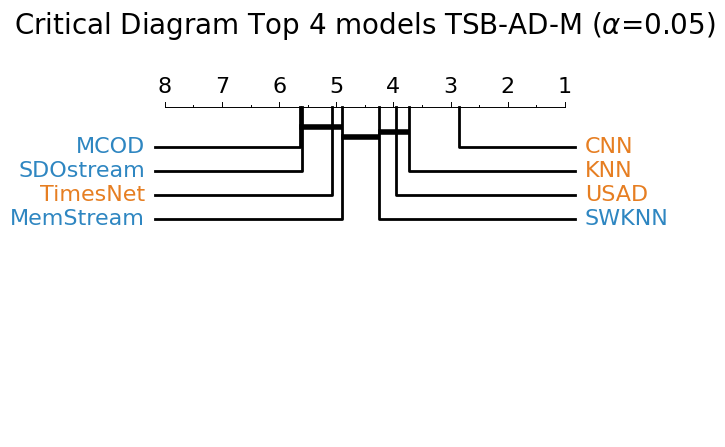

In [21]:
Study_pool = ['CNN', 'USAD', 'TimesNet','KNN', 'SWKNN', 'MemStream', 'SDOstream','MCOD']

df_filter = df_AUC_PR_full[Study_pool +['file']]




eval_list = []
for index, row in df_filter.iterrows():
    for method in Study_pool:#Comparison_Pool + Streaming_Pool
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
ranking = average_ranks.keys().to_list()[::-1]

graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=7, textspace=1.5, highlight=Streaming_Pool)
print('ranking:', ranking[:10])
plt.title("Critical Diagram Top 4 models TSB-AD-M ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

ranking: ['CNN', 'SWKNN', 'KNN', 'TimesNet', 'MemStream', 'MCOD', 'SDOstream', 'USAD']


C:\Users\d66285\AppData\Local\Temp\ipykernel_23208\87067950.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


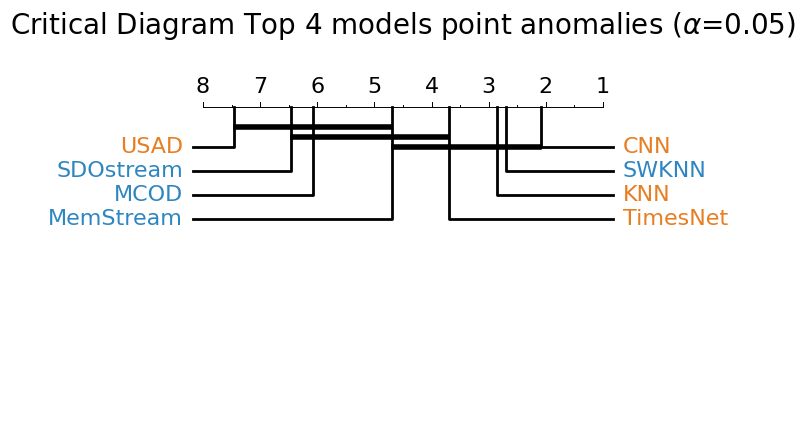

In [22]:
point_list = ['115_PSM_id_1_Facility_tr_50000_1st_129872.csv', '116_TAO_id_1_Environment_tr_500_1st_3.csv', '117_TAO_id_2_Environment_tr_500_1st_1.csv',
               '118_TAO_id_3_Environment_tr_500_1st_7.csv', '119_TAO_id_4_Environment_tr_500_1st_1.csv', '121_TAO_id_6_Environment_tr_500_1st_7.csv', 
               '122_TAO_id_7_Environment_tr_500_1st_19.csv', '123_TAO_id_8_Environment_tr_500_1st_62.csv', '124_TAO_id_9_Environment_tr_500_1st_1.csv', 
               '125_TAO_id_10_Environment_tr_500_1st_9.csv', '127_TAO_id_12_Environment_tr_500_1st_24.csv', '128_TAO_id_13_Environment_tr_500_1st_7.csv', 
               '137_CreditCard_id_1_Finance_tr_500_1st_541.csv']

Study_pool = ['CNN', 'USAD', 'TimesNet','KNN', 'SWKNN', 'MemStream', 'SDOstream','MCOD']
df_filter = df_AUC_PR_full[df_AUC_PR_full['file'].isin(point_list)][Study_pool+ ['file']]


eval_list = []
for index, row in df_filter.iterrows():
    for method in Study_pool:# Comparison_Pool + Streaming_Pool
        eval_list.append([method, row['file'], row[method]])
eval_df = pd.DataFrame(eval_list, columns=['classifier_name', 'dataset_name', 'accuracy'])
p_values, average_ranks, _ = Friedman_Nemenyi(df_perf=eval_df, alpha=0.05)
ranking = average_ranks.keys().to_list()[::-1]

graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=7, textspace=1.5, highlight=Streaming_Pool)
print('ranking:', ranking[:10])
plt.title("Critical Diagram Top 4 models point anomalies ({}=0.05)".format(r'$\alpha$'),fontsize=20)
plt.tight_layout()
plt.show()

### Drift Analysis

In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_aucpr_drift_vs_total(
    total_df: pd.DataFrame,
    drift_df: pd.DataFrame,
    agg: str | None = "Mean",            # "mean", "median", or None
    ad_meta_path: str = "../meta_data/AD_multi.csv",
    annotate: bool = True,
    figsize: tuple = (10, 8),
    alpha: float = 0.9,
    savepath: str | None = None,
    show: bool = False,
    axis_mode: str = "auto",
    streaming_colors: tuple = ("#1f77b4", "#ff7f0e"),


    point_scale: float = 2.0,          
    label_scale: float = 3.0,          
    legend_fontsize: int = 14,          
    title_fontsize: int = 20,         
    axes_labelsize: int = 16,           
    tick_labelsize: int = 14,            
    use_jitter: bool = True,           
    jitter_strength: float = 0.002,     

    name_shortcuts: dict | None = None
):
    # Goal: Compare AUC-PR performance on datasets with Concept Drift vs Total datasets
    # Points are colored and shaped by streaming capability (Streaming=Square, Online=Circle)

    if name_shortcuts is None:
        name_shortcuts = {
            "AnomalyTransformer": "AT",
            "OmniAnomaly": "OA",
            "TimesNet": "TN",
            "AutoEncoder": "AE",
            "IForest": "IF",
            "MemStream": "MS",
            "SDOstream": "SDOs",
            "RobustPCA": "RobPCA",
        }


    if agg not in (None, "Mean", "Median"):
        raise ValueError("agg must be one of: None, 'mean', 'median'.")

    common_models = [c for c in total_df.columns if c in drift_df.columns]
    if len(common_models) == 0:
        raise ValueError("No common model columns between total and drift subsets.")

    total = total_df[common_models].copy()
    drift = drift_df[common_models].copy()

    try:
        meta = pd.read_csv(ad_meta_path)
    except Exception as e:
        raise FileNotFoundError(f"Cannot read {ad_meta_path}: {e}")

    meta = meta[['AD_name', 'streaming']].dropna()
    model2streaming = dict(zip(meta['AD_name'], meta['streaming']))


    fig = plt.figure(figsize=figsize)
    ax = fig.gca()

    all_x, all_y = [], []
    legend_entries = {1: streaming_colors[0], 0: streaming_colors[1]}

    scatter_size_agg = 70 * point_scale
    scatter_size_noagg = 35 * point_scale
    base_annot_size = int(9 * label_scale)


    texts = []

    def short_name(model: str) -> str:
        return name_shortcuts.get(model, model)

    def maybe_jitter(x: float, y: float) -> tuple[float, float]:
        if not use_jitter:
            return x, y
        return (x + np.random.uniform(-jitter_strength, jitter_strength),
                y + np.random.uniform(-jitter_strength, jitter_strength))

    if agg in ("Mean", "Median"):
        reducer_total = total.mean if agg == "Mean" else total.median
        total_agg = reducer_total(axis=0, skipna=True)
        reducer_drift = drift.mean if agg == "Mean" else drift.median
        drift_agg = reducer_drift(axis=0, skipna=True)

        for model in common_models:
            x = float(total_agg[model])
            y = float(drift_agg[model])
            if np.isnan(x) or np.isnan(y):
                continue

            streaming_flag = model2streaming.get(model, 0)
            color = legend_entries.get(streaming_flag, "#7f7f7f")

            if streaming_flag == 0:
                marker = 'o'
                # alpha = 0.5
            else:
                marker = 's'
                # alpha = 0.9

            xj, yj = maybe_jitter(x, y)

            ax.scatter(xj, yj, s=scatter_size_agg, color=color, edgecolor="k", alpha=alpha, marker = marker)
            all_x.append(xj); all_y.append(yj)

            if annotate:
                txt = ax.annotate(
                    short_name(model), (xj, yj),
                    xytext=(7, 5),      
                    textcoords="offset points",
                    fontsize=base_annot_size,
                    clip_on=True
                )
                texts.append(txt)

        title_suffix = f"{agg}"

        agg_stats = pd.DataFrame({
            "total": total_agg,
            "drift": drift_agg,
            "delta_drift_minus_total": drift_agg - total_agg
        }).sort_values("delta_drift_minus_total", ascending=False)

    else:
        # No aggregation
        for model in common_models:
            x_arr = total[model].to_numpy(dtype=float, copy=True)
            y_arr = drift[model].to_numpy(dtype=float, copy=True)
            mask = ~np.isnan(x_arr) & ~np.isnan(y_arr)
            x_arr = x_arr[mask]; y_arr = y_arr[mask]
            if x_arr.size == 0:
                continue

            streaming_flag = model2streaming.get(model, 0)
            color = legend_entries.get(streaming_flag, "#7f7f7f")

            if use_jitter:
                x_arr = x_arr + np.random.uniform(-jitter_strength, jitter_strength, size=x_arr.shape)
                y_arr = y_arr + np.random.uniform(-jitter_strength, jitter_strength, size=y_arr.shape)

            ax.scatter(x_arr, y_arr, s=scatter_size_noagg, color=color, edgecolor="k", alpha=min(alpha, 0.85))
            all_x.extend(x_arr.tolist()); all_y.extend(y_arr.tolist())

            if annotate:
                xm = float(np.nanmean(x_arr)); ym = float(np.nanmean(y_arr))
                txt = ax.annotate(
                    short_name(model), (xm, ym),
                    xytext=(7, 5),
                    textcoords="offset points",
                    fontsize=base_annot_size,
                    clip_on=True
                )
                texts.append(txt)

        title_suffix = ""
        agg_stats = None

    if len(all_x) == 0 or len(all_y) == 0:
        raise ValueError("No valid (total, drift) pairs after NaN filtering.")

    axis_mode_l = axis_mode.lower()
    if axis_mode_l not in ("auto", "fixed"):
        raise ValueError("axis_mode must be 'auto' or 'fixed'.")

    if axis_mode_l == "auto":
        min_val = float(min(np.min(all_x), np.min(all_y)))
        max_val = float(max(np.max(all_x), np.max(all_y)))
        pad = (max_val - min_val) * 0.05 if max_val > min_val else 0.02
        xmin = max(0.0, min_val - pad)
        xmax = min(1.0, max_val + pad)
    else:
        xmin, xmax = 0.0, 1.0

    ax.plot([xmin, xmax], [xmin, xmax], color="red", linestyle="--", linewidth=1.5, label="y = x")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.set_aspect('equal', adjustable='box')

    x = np.linspace(xmin, xmax, 256)

    ymin, ymax = ax.get_ylim()

    ax.fill_between(
        x, x, ymax,               
        color="#90EE90", alpha=0.05,  
        zorder=0
    )

    ax.fill_between(
        x, ymin, x,               
        color="#F08080", alpha=0.05,
        zorder=0
    )


    ax.set_title(f"{title_suffix} AUC-PR on TSB-drift vs TSB-AD-M \ drift ", fontsize=title_fontsize)
    ax.set_xlabel("AUC-PR TSB-AD-M", fontsize=axes_labelsize)
    ax.set_ylabel("AUC-PR TSB-drift", fontsize=axes_labelsize)

    # ax.set_ylim(xmin, 0.46)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    # ax.set_xticks(np.arange(0, 0.46, 0.1))

    ax.grid(True, linestyle="--", alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

    
    legend_elements = [
        Line2D([0], [0], marker='s', color='w',
            markerfacecolor=streaming_colors[0], markeredgecolor='k',
            markersize=20, label='Streaming'),
        Line2D([0], [0], marker='o', color='w',
            markerfacecolor=streaming_colors[1], markeredgecolor='k',
            markersize=20, label='Online')
    ]

    labels = ["Streaming", "Online"]
    ax.legend(legend_elements, labels, loc="best", fontsize=legend_fontsize, frameon=True)
      
    _spread_labels_vertically(ax, texts)

    # apply_font_to_axes(ax, family_name)
    fig.tight_layout()
    

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    return {
        "common_models": common_models,
        "agg_stats": agg_stats
    }


def _spread_labels_vertically(ax, texts, dy_fraction: float = 0.012, cycles: int = 3):
    """
    Simple fallback
    """
    if not texts:
        return

    ymin, ymax = ax.get_ylim()
    dy = (ymax - ymin) * dy_fraction

    for _ in range(cycles):
        for i, t1 in enumerate(texts):
            x1, y1 = t1.get_position()
            for j, t2 in enumerate(texts):
                if j <= i:
                    continue
                x2, y2 = t2.get_position()
                if abs(x1 - x2) < 0.01 * (ax.get_xlim()[1] - ax.get_xlim()[0]) and abs(y1 - y2) < dy * 0.8:
                    t2.set_position((x2, y2 + dy))


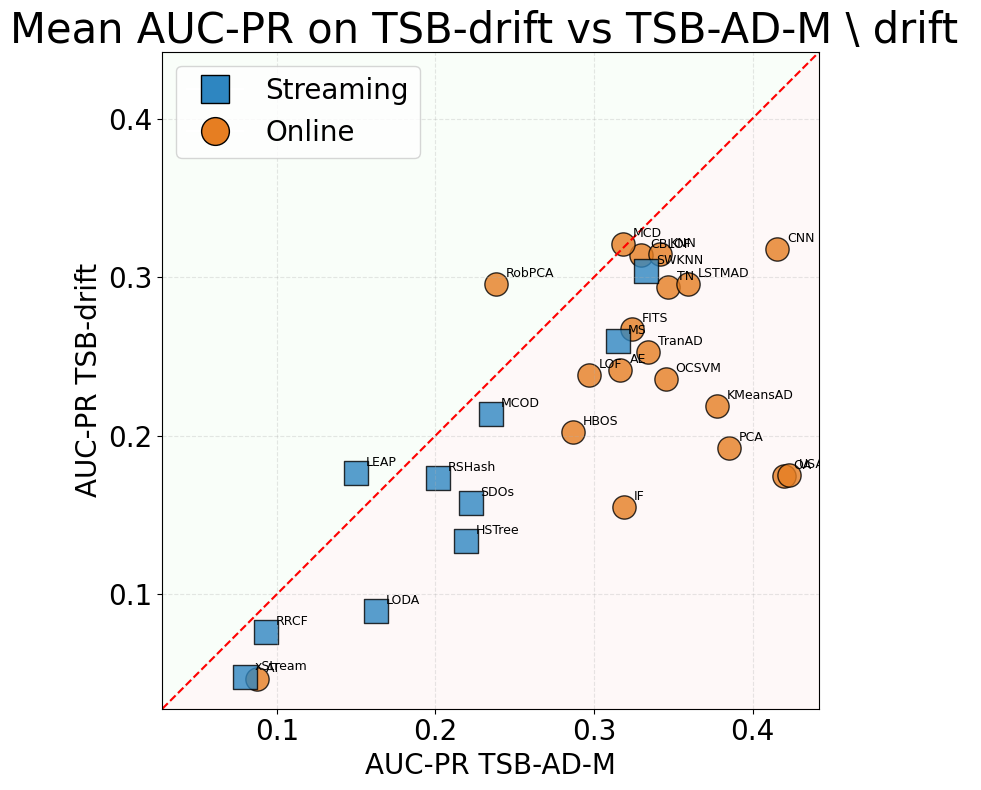

In [24]:
df_sorted = pd.read_csv('benchmark_eval_results/CD.csv')
CD_list = df_sorted[df_sorted['CD'] == 1]['file'].values.tolist()
CD_df_AUC_PR_full = df_AUC_PR_full[df_AUC_PR_full['file'].isin(CD_list)]
no_CD_df_AUC_PR_full = df_AUC_PR_full[~df_AUC_PR_full['file'].isin(CD_list)]

out = plot_aucpr_drift_vs_total(total_df=no_CD_df_AUC_PR_full[Comparison_Pool + Streaming_Pool],drift_df=CD_df_AUC_PR_full[Comparison_Pool + Streaming_Pool], 
                             agg = 'Mean',
                                 ad_meta_path = "../meta_data/AD_multi.csv",
    annotate =True,              # Annotations des modèles (pertinent surtout si agrégation)
    figsize = (10, 8),
    alpha = 0.8,
    savepath = None,
    show= True,                 # Laisser False par défaut
    axis_mode = 'auto',
    streaming_colors = ('#2E86C1', '#E67E22'),

    point_scale =4.0,
    label_scale = 1.0,
    legend_fontsize = 20, 
    axes_labelsize = 20,

    title_fontsize = 30,
    tick_labelsize = 20,
    
)




In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.colors as mcolors
from typing import List

def plot_gain_drift_vs_total(
    df_AUC_PR_cd: pd.DataFrame,
    df_AUC_PR_total: pd.DataFrame,
    metric: str = "absolute", #or relative
    figsize: tuple = (12, 6),
    savepath: str | None = None,
    show: bool = True,
    title: str | None = None,
    annotate: bool = False,
    streaming_pool: List | None = None,
):
    # Goal: Calculate and visualize the performance gain/loss between 
    # datasets with Concept Drift and the total benchmark set.

    cd_idxed = df_AUC_PR_cd.set_index('file') if 'file' in df_AUC_PR_cd.columns else df_AUC_PR_cd.copy()
    on_idxed = df_AUC_PR_total.set_index('file') if 'file' in df_AUC_PR_total.columns else df_AUC_PR_total.copy()

    common_models = sorted(set(cd_idxed.columns) & set(on_idxed.columns))
    if not common_models:
        raise ValueError("No common model columns between the two DataFrames.")

    cd = cd_idxed
    on = on_idxed

    if metric == "absolute":
        values = cd[common_models].mean(axis=0, skipna=True) - on[common_models].mean(axis=0, skipna=True)
        y_label = "Mean AUC-PR gain"
        if title is None:
            title = "Mean AUC-PR Gain (TSB-drift − TSB-AD-M) per model"
    elif metric == "relative":
        values = (cd[common_models].mean(axis=0, skipna=True) - on[common_models].mean(axis=0, skipna=True)) / on[common_models].mean(axis=0, skipna=True) * 100
        y_label = "Mean % improvement vs TSB-AD-M"
        if title is None:
            title = "Mean % Improvement (TSB-drift vs TSB-AD-M) per model"
    else:
        raise ValueError("metric must be 'absolute' or 'relative'.")

    values_sorted = values.sort_values(ascending=False)

    cmap = LinearSegmentedColormap.from_list("darkred_white_darkgreen", ["#8B0000", "#FFFFFF", "#006400"])
    vmin, vmax = -0.15, 0.035
    m = max(abs(vmin), abs(vmax))
    norm = TwoSlopeNorm(vmin=-m, vcenter=0.0, vmax=m)

    rgba_colors = [cmap(norm(val)) for val in values_sorted.values]
    hex_colors = [mcolors.to_hex(c) for c in rgba_colors]

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(values_sorted.index, values_sorted.values, color=rgba_colors, edgecolor="k", linewidth=0.8)

    ax.axhline(0.0, color="black", linewidth=1.0)
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_ylim(-0.26, 0.07)
    ax.tick_params(axis='y', labelsize=25)
    
    display_map = {
        "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN", "TranAD": "TrAD",
        "OCSVM": "SVM", "LSTMAD":"LSTM", "RobustPCA": "RPCA", "AnomalyTransformer": "AT",
        "KMeansAD": "KMAD", "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
        'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST', "SWKNN": 'SKNN'
    }
    display_labels = [display_map.get(name, name) for name in values_sorted.index]

    ax.set_xticks(range(len(values_sorted)))
    ax.set_xticklabels(display_labels, rotation=90, ha="center", fontsize=37)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_xlim(-0.5, len(values_sorted) - 0.5)

    if annotate:
        for rect, val in zip(bars, values_sorted.values):
            ax.annotate(f"{val:.2f}",
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    return pd.DataFrame({"value": values_sorted.values, "color": hex_colors}, index=values_sorted.index)

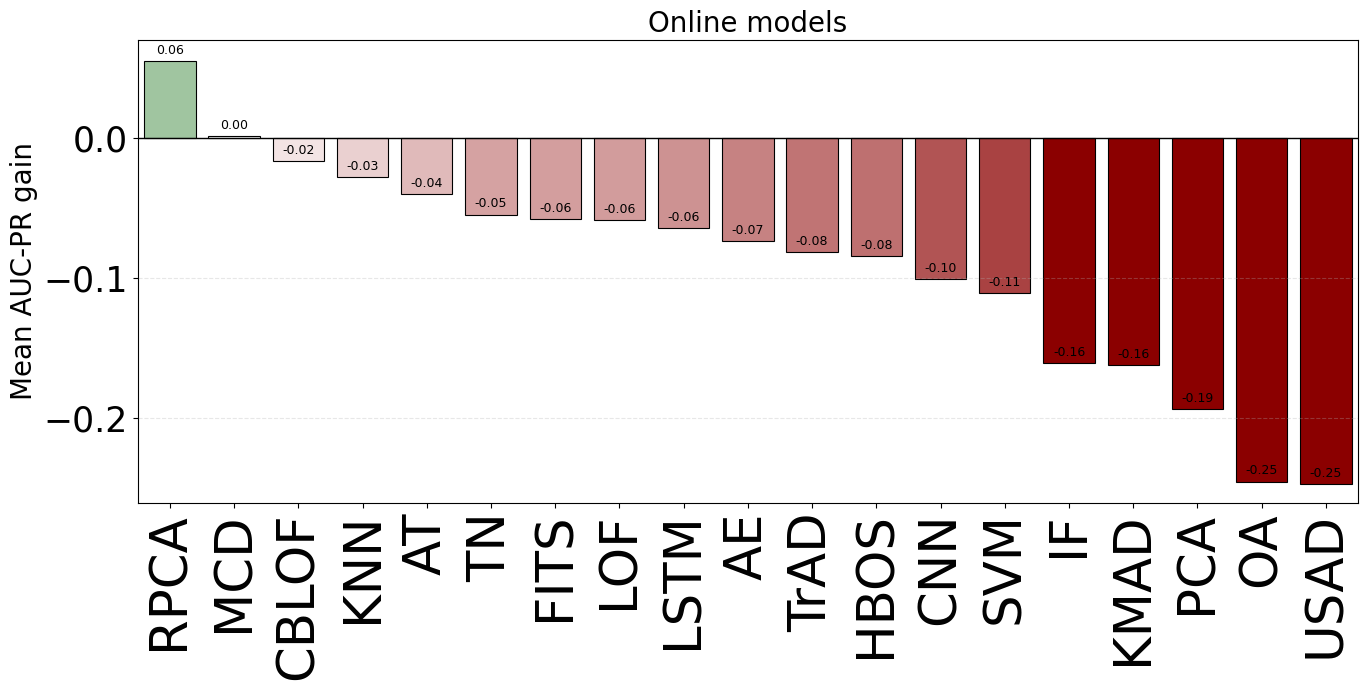

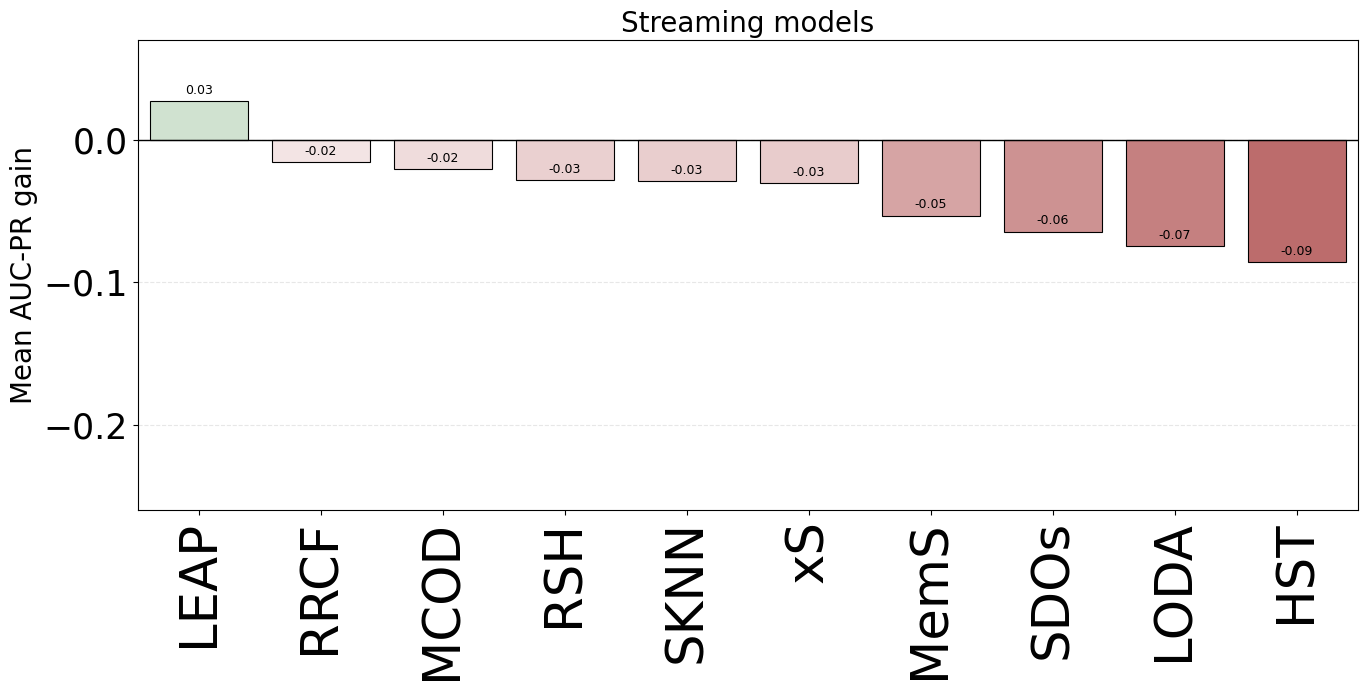

In [26]:
out =plot_gain_drift_vs_total(
    df_AUC_PR_cd =CD_df_AUC_PR_full [Comparison_Pool ],
    df_AUC_PR_total=no_CD_df_AUC_PR_full[Comparison_Pool ],
    metric = "absolute",           # "absolute" (gain) or "relative" (% improvement)
    streaming_pool = Streaming_Pool,
    figsize= (14, 7),
    savepath= None,
    show = True,
    title = "Online models", #"Mean Gain (TSB-drift − TSB-AD\drift) for Online models",
    annotate = True ,           
)
out =plot_gain_drift_vs_total(
    df_AUC_PR_cd =CD_df_AUC_PR_full [Streaming_Pool ],
    df_AUC_PR_total=no_CD_df_AUC_PR_full[Streaming_Pool ],
    metric = "absolute",           # "absolute" (gain) or "relative" (% improvement)
    streaming_pool = None,
    figsize= (14, 7),
    savepath= None,
    show = True,
    title = "Streaming models", 
    annotate = True ,             
)



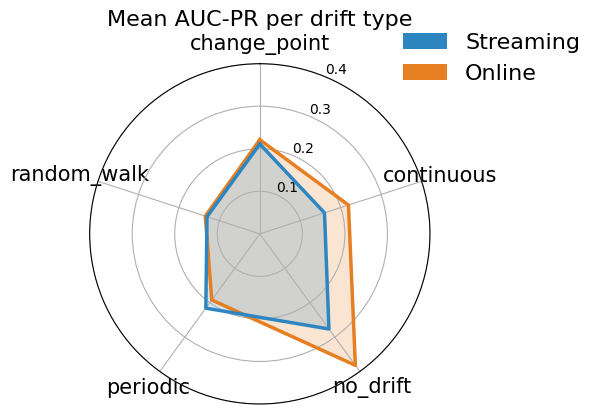

In [27]:
DRIFT_TYPES = ['continuous', 'random_walk', 'change_point', 'periodic']
TOP_STREAMING = ['SWKNN', 'MemStream', 'SDOstream', 'MCOD']
TOP_ONLINE = ['CNN', 'USAD', 'TimesNet', 'KNN']
COLOR_ONLINE = '#E67E22'
COLOR_STREAMING = '#2E86C1'

spider_plot_CD(df_ref = df_AUC_PR_on, 
                df_new = df_AUC_PR_stream, 
                TOP_REF = TOP_ONLINE, 
                TOP_NEW = TOP_STREAMING, 
                COLOR_REF = COLOR_ONLINE, 
                COLOR_NEW = COLOR_STREAMING,
                label_ref='Online',
                label_new='Streaming',
                title = "Mean AUC-PR per drift type")

### Efficiency Analysis

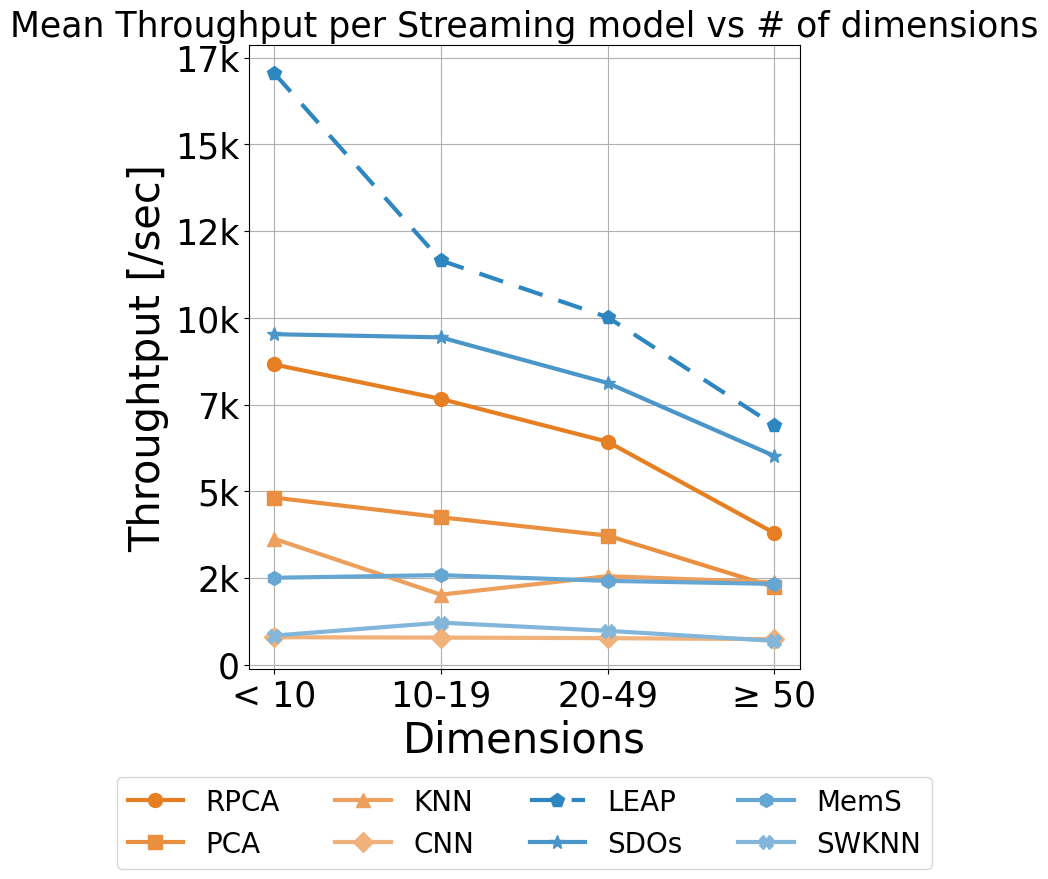

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.ticker import FuncFormatter

def generate_palette(hex_color, n, light_max=0.4):
    """
    Generates n lighter variations of a base color.
    light_max = 0.4 ensures the color never becomes pure white.
    """
    base = np.array(to_rgb(hex_color))
    colors = []
    for i in range(n):
        light_factor = light_max * (i / (n - 1)) if n > 1 else 0  
        color = base + (1 - base) * light_factor
        colors.append(color)
    return colors

Study_stream = ['LEAP', 'SDOstream', 'MemStream', 'SWKNN']
Study_online = ['RobustPCA', 'PCA', 'KNN', 'CNN']

bins = [-np.inf, 10, 20, 50, np.inf]
labels = ["< 10", "10-19", "20-49", "≥ 50"]

merged_throughput_df['features_bin'] = pd.cut(
    merged_throughput_df['features'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

merged_throughput_df['features_bin'] = merged_throughput_df['features_bin'].cat.set_categories(labels, ordered=True)

avg_by_bin = merged_throughput_df.groupby('features_bin', observed=True).mean(numeric_only=True)

def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else str(int(x))


plt.figure(figsize=(8, 9))
models = Study_online + Study_stream

display_map = {
    "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN",
    "RobustPCA": "RPCA", "AnomalyTransformer": "AT", "KMeansAD": "KMAD",
    "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
    'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST'
}

orange_palette = generate_palette("#E67E22", len(Study_online))
blue_palette = generate_palette("#2E86C1", len(Study_stream))

stream_idx = 0
online_idx = 0
all_markers = ['o', 's', '^', 'D', 'p', '*', 'h', 'X', 'd']

for i, model in enumerate(models):
    linestyle = '-'
    dashes = None
    marker = all_markers[i % len(all_markers)]

    if model in Streaming_Pool:
        color = blue_palette[stream_idx]
        stream_idx += 1
        if model == 'LEAP': 
            linestyle = '--'
            dashes = (6, 4)
    else:
        color = orange_palette[online_idx]
        online_idx += 1

    line = plt.plot(
        avg_by_bin.index,
        avg_by_bin[model],
        marker=marker,
        color=color,
        label=display_map.get(model, model),
        linewidth=3,
        markersize=10,
        linestyle=linestyle,
    )[0]

    if dashes is not None:
        line.set_dashes(dashes)


plt.title("Mean Throughput per Streaming model vs # of dimensions", fontsize=25)
plt.xlabel('Dimensions', fontsize=30)
plt.ylabel('Throughtput [/sec]', fontsize=30)
plt.yticks(fontsize=25)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.xticks(ticks=labels, fontsize=25)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=20)

plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

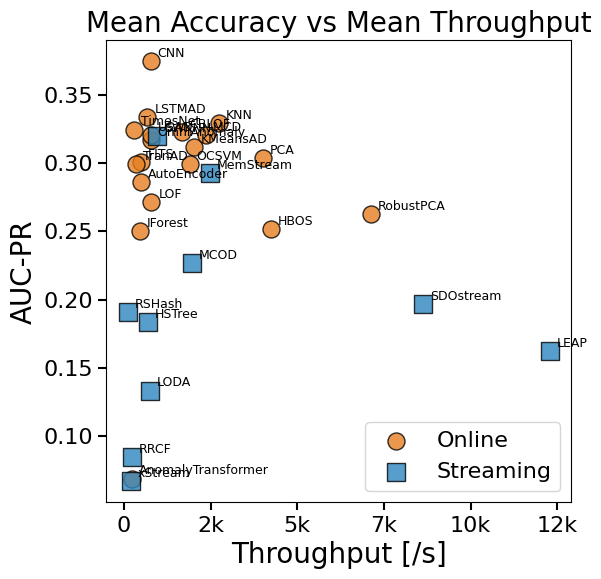

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

throughput = merged_throughput_df[Comparison_Pool + Streaming_Pool].mean(axis=0)
values = df_AUC_PR_full[Streaming_Pool + Comparison_Pool].mean(axis=0, skipna=True)

plt.figure(figsize=(6, 6))
labeled_streaming = False
labeled_online = False

# Plot Accuracy vs Throughput with distinct markers for Streaming (Square) and Online (Circle)
for model in Comparison_Pool + Streaming_Pool:
    x = float(throughput[model])
    y = float(values[model])
    
    if np.isnan(x) or np.isnan(y):
        continue

    if model in Streaming_Pool:
        color = '#2E86C1'
        label = 'Streaming' if not labeled_streaming else None
        labeled_streaming = True
        marker = 's'
    else:
        color = '#E67E22'
        label = 'Online' if not labeled_online else None
        labeled_online = True
        marker = 'o'

    plt.scatter(x, y, color=color, label=label, s=150, edgecolor="k", marker=marker, alpha=0.8)
    plt.annotate(model, (x, y), xytext=(5, 3), textcoords="offset points", fontsize=9)



ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color("black")

ax.tick_params(
    bottom=True, top=False, left=True, right=False,
    direction='out', length=6, width=1.5,
    colors='black', labelsize=16
)

ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.ylabel('AUC-PR', fontsize=20)
plt.xlabel('Throughput [/s]', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Mean Accuracy vs Mean Throughput', fontsize=20)
plt.grid(False)
plt.legend(loc='lower right', fontsize=16)
plt.show()

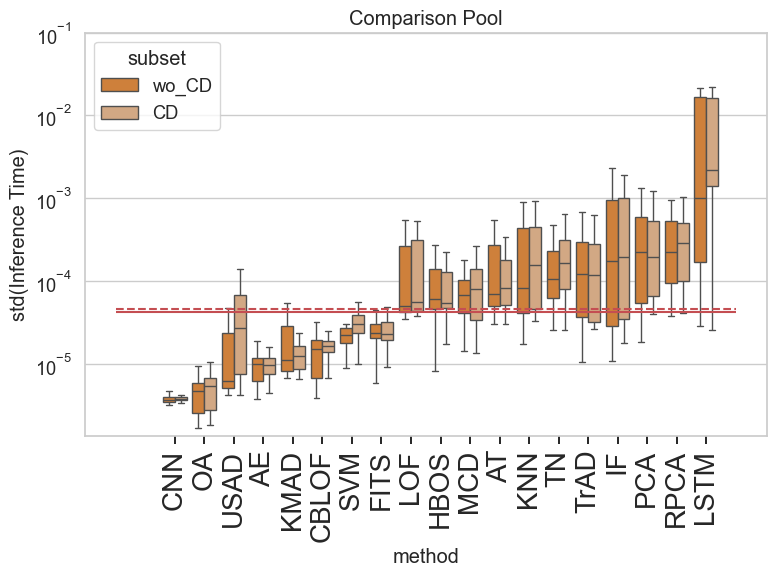

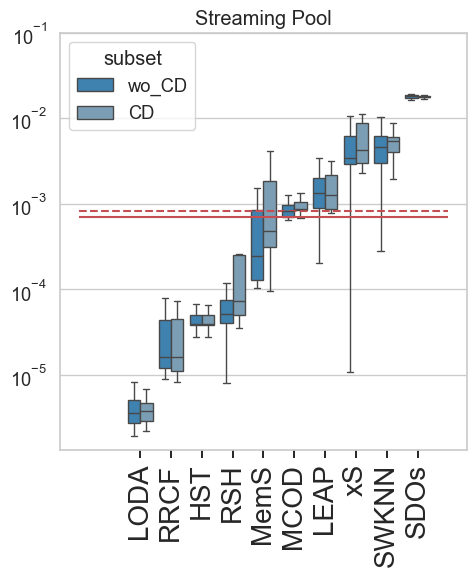

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator

sns.set_theme(style="whitegrid", font_scale=1.2)

df_full = pd.read_csv("benchmark_eval_results/time/std_inference.csv")
df_sorted = pd.read_csv('benchmark_eval_results/CD.csv')
CD_list = df_sorted[df_sorted['CD'] == 1]['file'].values.tolist()

display_map = {
    "OmniAnomaly": "OA", "AutoEncoder": "AE", "TimesNet": "TN", "RobustPCA": "RPCA",
    "AnomalyTransformer": "AT", "OCSVM":"SVM", "LSTMAD": "LSTM", "TranAD": "TrAD",
    "KMeansAD": "KMAD", "SDOstream":"SDOs", "MemStream": "MemS", "xStream" : 'xS',
    'IForest': 'IF', 'RSHash': 'RSH', 'HSTree': 'HST'
}

display_labels_comp = [display_map.get(name, name) for name in Comparison_Pool]
display_labels_stream = [display_map.get(name, name) for name in Streaming_Pool]

def longify(df, subset, pool):
    out = df.melt(var_name="method", value_name="value")
    out["subset"] = subset
    out["pool"] = pool
    return out

df_all_C = df_full[~df_full["file"].isin(CD_list)][Comparison_Pool]
df_cd_C = df_full[df_full["file"].isin(CD_list)][Comparison_Pool]
df_all_S = df_full[~df_full["file"].isin(CD_list)][Streaming_Pool]
df_cd_S = df_full[df_full["file"].isin(CD_list)][Streaming_Pool]

df_C = pd.concat([longify(df_all_C, "wo_CD", "Comparison"), longify(df_cd_C, "CD", "Comparison")])
df_S = pd.concat([longify(df_all_S, "wo_CD", "Streaming"), longify(df_cd_S, "CD", "Streaming")])

order_comp = df_all_C.median().sort_values().index.tolist()
order_stream = df_all_S.median().sort_values().index.tolist()

ymin = min(df_C["value"].min(), df_S["value"].min()) * 0.8
ymax = 10e-2

# --- Plot 1: Comparison Pool inference Stability ---
plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    data=df_C, x="method", y="value", hue="subset",
    order=order_comp, hue_order=["wo_CD","CD"],
    showfliers=False, palette=['#E67E22', "#DFA777"]
)

# Add horizontal reference lines for median stability
plt.hlines(np.median(df_all_C[Comparison_Pool]), xmin=-2, xmax=19, color='r')
plt.hlines(np.median(df_cd_C[Comparison_Pool]), xmin=-2, xmax=19, color='r', linestyle='--')

plt.yscale("log")
plt.ylim(ymin, ymax)
plt.xticks(ticks=range(len(Comparison_Pool)), labels=display_labels_comp, rotation=90, fontsize=20)
ax.tick_params(axis='x', which='major', length=6, width=1.2, color='black', bottom=True)
ax.set_ylabel("std(Inference Time)")
plt.title("Comparison Pool")
plt.tight_layout()
plt.show()

# --- Plot 2: Streaming Pool inference Stability ---
plt.figure(figsize=(5, 6))
ax = sns.boxplot(
    data=df_S, x="method", y="value", hue="subset",
    order=order_stream, hue_order=["wo_CD","CD"],
    showfliers=False, palette=['#2E86C1',"#71A0BE"]
)

# Add horizontal reference lines for median stability
plt.hlines(np.median(df_all_S[Streaming_Pool]), xmin=-2, xmax=10, color='r')
plt.hlines(np.median(df_cd_S[Streaming_Pool]), xmin=-2, xmax=10, color='r', linestyle='--')



plt.yscale("log")
plt.ylim(ymin, ymax)
plt.xticks(ticks=range(len(Streaming_Pool)), labels=display_labels_stream, rotation=90, fontsize=20)
ax.tick_params(axis='x', which='major', length=6, width=1.2, color='black', bottom=True)
ax.yaxis.set_major_locator(LogLocator(base=10))
ax.yaxis.set_minor_locator(LogLocator(base=10))
ax.set_xlabel("")
ax.set_ylabel("")
plt.title("Streaming Pool")
plt.tight_layout()
plt.show()